# Modelo de Machine Learning

Iniciamos o notebook importando todas as bibliotecas que serão úteis. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score,confusion_matrix,ConfusionMatrixDisplay,precision_score,make_scorer
from sklearn.model_selection import train_test_split,GridSearchCV

In [2]:
import sklearn
print(f'A versão atual do scikit-learn é: {sklearn.__version__}')

A versão atual do scikit-learn é: 1.0.1


In [3]:
df = pd.read_csv('desafio_manutencao_preditiva_treino_final.csv')
df.head()

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,diff_temperature_air_process,power_W,wear_x_torque_minNm
0,M,298.1,308.6,1551,42.8,0,No Failure,10.5,6951.6,0.0
1,L,298.2,308.7,1408,46.3,3,No Failure,10.5,6826.7,138.9
2,L,298.2,308.7,1408,40.0,9,No Failure,10.5,5897.8,360.0
3,M,298.1,308.6,1425,41.9,11,No Failure,10.5,6252.6,460.9
4,L,298.1,308.6,1558,42.4,14,No Failure,10.5,6917.7,593.6


In [4]:
X_columns = df.drop(columns=['failure_type']).columns
X = df[X_columns]
y = df['failure_type']
display(X.head())
print(y[:5])

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,diff_temperature_air_process,power_W,wear_x_torque_minNm
0,M,298.1,308.6,1551,42.8,0,10.5,6951.6,0.0
1,L,298.2,308.7,1408,46.3,3,10.5,6826.7,138.9
2,L,298.2,308.7,1408,40.0,9,10.5,5897.8,360.0
3,M,298.1,308.6,1425,41.9,11,10.5,6252.6,460.9
4,L,298.1,308.6,1558,42.4,14,10.5,6917.7,593.6


0    No Failure
1    No Failure
2    No Failure
3    No Failure
4    No Failure
Name: failure_type, dtype: object


## Classificação binária

Neste arquivo  abordaremos o caso de uma classificação binária, ou seja, Failure (1) ou No Failure (0). Para isso, vamos converter nossa variável y em binário sendo 0 para No Failure e 1 para qualquer outro tipo de falha. 

In [5]:
y = np.where(y == 'No Failure',0,1)
print(y.sum())
print(y[:10])
print(1 - np.sum(y)/len(y))

232
[0 0 0 0 0 0 0 0 0 0]
0.9652017399130044


No total, são 232 registros indicando algum tipo de falha. Por isso, vamos comparar estes dados com o original do dataframe. 

Note que a ultima mensagem da linha faz referência à quantidade de 'Failure' em relação ao número de 'No Failure'. Em resumo, se um modelo cego chutasse que todas as saídas fossem 'No Failure', ele acertaria 96,5% das vezes. Isso é um indicativo de que a acurácia não é o modelo adequado para avaliar estes dados. 

In [6]:
print(df['failure_type'][df['failure_type'] != 'No Failure'].value_counts().sum())
df['failure_type'].head(10)

232


0    No Failure
1    No Failure
2    No Failure
3    No Failure
4    No Failure
5    No Failure
6    No Failure
7    No Failure
8    No Failure
9    No Failure
Name: failure_type, dtype: object

Como os os registros batem, podemos continuar nossa análise. Primeiramente vamos dividor o conjunto em dados de treino e dados de validação. 

In [7]:
X_train, X_val,y_train, y_val = train_test_split(X,y,test_size=0.30,random_state=42)
print(np.sum(y_train)/len(y_train),np.sum(y_val)/len(y_val))

0.03536219459922846 0.033483258370814596


Por tratar-se de dados desbalanceados, vamos tentar uma abordagem na qual fazemos o balanço das classes. 

In [8]:
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes = np.unique(y_train), y = y_train)
class_weights

array([ 0.51832926, 14.13939394])

In [9]:
#Transformation od categorical features
cat_features = ['type']
print(f'Categorical features: {cat_features}')
num_features = list(df.select_dtypes(exclude='object').columns)
print(f'Numerical features: {num_features}')

Categorical features: ['type']
Numerical features: ['air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 'torque_nm', 'tool_wear_min', 'diff_temperature_air_process', 'power_W', 'wear_x_torque_minNm']


In [10]:
#####CRIANDO UM SCORE######
def false_negative_rate(y_true, y_pred):
    """
    Esta métrica calcula a taxa de falso negativo (TFN) usando os valores reais e previstos da variável alvo. 
    A TFN é definida como a proporção de falsos negativos (FN) dentro de todos os positivos reais (TP + FN).
        
    Parametros:
        - y_true (array-like): An array or list containing the actual target variable values
        - y_pred (array-like): An array or list containing the predicted target variable values
    
    Returns:
        - float: o valor TFN calculado
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    
    return (abs(fn / (fn + tp)))

In [11]:
miss_rate = make_scorer(
    false_negative_rate,
    greater_is_better=False,
    needs_proba=False,
)

Acabamos de criar a métrica acima, na qual quanto menor, melhor. 
Basicamente ela avalia, dentre os dados que REALMENTE FALHAM, quais estamos errando. Em tese, na pior das hipóteses, erraremos todos, dando um resultado igual a 1. 
Resultados próximos de zero indica que estamos diminuindo o numerador, ou seja, os falsos negativos. Caso não tenhamos nenhum falso negativo, o resultado dá zero. 

Julgo que esta métrica seja relevante pois é melhor prever que um equipamento dará problema, e dar a devida revisão para evitar, do que acabar com uma falha em uma peça que não havia sido prevista, logo não estava nem sendo monitorada. 

## Regressão logística

In [12]:
#Transformação:
#    categóricos serão submetidos a One hot Encoder
#    numéricos serão submetidos a StandardScaler
#

transformation = ColumnTransformer(
    [('categorical',OneHotEncoder(handle_unknown='ignore'),cat_features),
    ('numerical',StandardScaler(),num_features)]
)

#Modelo usando os dados balanceados pelas classes
#model = Pipeline(steps=[
#    ('column_transformation',transformation),
#    ('Classifier',LogisticRegression(max_iter=500,class_weight={0:class_weights[0],1:class_weights[1]}))
#])

model = Pipeline(steps=[
    ('column_transformation',transformation),
    ('Classifier',LogisticRegression(max_iter=500))
])


display(model)

Pipeline(steps=[('column_transformation',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['type']),
                                                 ('numerical', StandardScaler(),
                                                  ['air_temperature_k',
                                                   'process_temperature_k',
                                                   'rotational_speed_rpm',
                                                   'torque_nm', 'tool_wear_min',
                                                   'diff_temperature_air_process',
                                                   'power_W',
                                                   'wear_x_torque_minNm'])])),
                ('Classifier', LogisticRegression(max_iter=500))])

In [13]:
param_grid = {
    'Classifier__C':[0.001,0.01,0.1,1,5,10],
    'Classifier__max_iter':[100,200,300,400,500]
}

search = GridSearchCV(model,
                      param_grid,
                      scoring= miss_rate,
                     cv = 5)
search.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformation',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['type']),
                                                                        ('numerical',
                                                                         StandardScaler(),
                                                                         ['air_temperature_k',
                                                                          'process_temperature_k',
                                                                          'rotational_speed_rpm',
                                                                          'torque_nm',
                                                                          'tool_wear_min',
                                                                          'diff_temperature_air_process',
                                                                          'power_W',
                                                                          'wear_x_torque_minNm'])])),
                                       ('Classifier',
                                        LogisticRegression(max_iter=500))]),
             param_grid={'Classifier__C': [0.001, 0.01, 0.1, 1, 5, 10],
                         'Classifier__max_iter': [100, 200, 300, 400, 500]},
             scoring=make_scorer(false_negative_rate, greater_is_better=False))

In [14]:
search.best_params_

{'Classifier__C': 5, 'Classifier__max_iter': 100}

In [15]:
search.cv_results_['mean_test_score'].mean()

-0.8646464646464643

In [16]:
model.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('column_transformation',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['type']),
                                                 ('numerical', StandardScaler(),
                                                  ['air_temperature_k',
                                                   'process_temperature_k',
                                                   'rotational_speed_rpm',
                                                   'torque_nm', 'tool_wear_min',
                                                   'diff_temperature_air_process',
                                                   'power_W',
                                                   'wear_x_torque_minNm'])])),
                ('Classifier', LogisticRegression(max_iter=500))])>

In [17]:
model.set_params(**search.best_params_)

Pipeline(steps=[('column_transformation',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['type']),
                                                 ('numerical', StandardScaler(),
                                                  ['air_temperature_k',
                                                   'process_temperature_k',
                                                   'rotational_speed_rpm',
                                                   'torque_nm', 'tool_wear_min',
                                                   'diff_temperature_air_process',
                                                   'power_W',
                                                   'wear_x_torque_minNm'])])),
                ('Classifier', LogisticRegression(C=5))])

In [18]:
model.fit(X_train,y_train)
y_pred = model.predict(X_val)

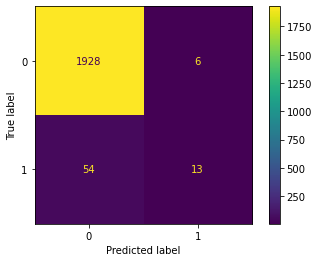

In [19]:
conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_val,y_pred),display_labels=model.classes_)
conf_mat.plot()

In [20]:
print(f'Miss rate: {false_negative_rate(y_val,y_pred):.3f}')

Miss rate: 0.806


## Árvore de Decisão

In [21]:
#Para a árvore de decisão não precisaremos de OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
transformation = ColumnTransformer(
    [('numerical',StandardScaler(),num_features),
    ('categorical',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1),cat_features)]
)

from sklearn.tree import DecisionTreeClassifier,plot_tree

#Modelo usando os dados balanceados pelas classes
#model_tree = Pipeline(steps=[
#    ('column_transformation',transformation),
#    ('Classifier',DecisionTreeClassifier(class_weight={0:class_weights[0],1:class_weights[1]}))
#])

model_tree = Pipeline(steps=[
    ('column_transformation',transformation),
    ('Classifier',DecisionTreeClassifier(random_state=42))
])


display(model_tree)

Pipeline(steps=[('column_transformation',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['air_temperature_k',
                                                   'process_temperature_k',
                                                   'rotational_speed_rpm',
                                                   'torque_nm', 'tool_wear_min',
                                                   'diff_temperature_air_process',
                                                   'power_W',
                                                   'wear_x_torque_minNm']),
                                                 ('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['type'])])),
                ('Classifier', DecisionTreeClassifier(random_state=42))])

In [22]:
param_grid = {
    'Classifier__criterion':['gini', 'entropy'],
    'Classifier__max_depth':[1,2,4,5],
    'Classifier__max_leaf_nodes':[1,2,4,5,10]
}

searchtree = GridSearchCV(model_tree,
                      param_grid,
                      scoring= miss_rate,
                     cv = 5)

searchtree.fit(X_train,y_train)

/home/marcio/anaconda3/envs/MarcioDS/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/marcio/anaconda3/envs/MarcioDS/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marcio/anaconda3/envs/MarcioDS/lib/python3.10/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/marcio/anaconda3/envs/MarcioDS/lib/python3.10/site-packages/sklearn/tree/_c

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformation',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         ['air_temperature_k',
                                                                          'process_temperature_k',
                                                                          'rotational_speed_rpm',
                                                                          'torque_nm',
                                                                          'tool_wear_min',
                                                                          'diff_temperature_air_process',
                                                                          'power_W',
                                                                          'wear_x_torque_minNm']),
                                                                        ('categorical',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['type'])])),
                                       ('Classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'Classifier__criterion': ['gini', 'entropy'],
                         'Classifier__max_depth': [1, 2, 4, 5],
                         'Classifier__max_leaf_nodes': [1, 2, 4, 5, 10]},
             scoring=make_scorer(false_negative_rate, greater_is_better=False))

In [23]:
searchtree.best_params_

{'Classifier__criterion': 'gini',
 'Classifier__max_depth': 5,
 'Classifier__max_leaf_nodes': 10}

In [24]:
model_tree.set_params(**searchtree.best_params_)
model_tree.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('column_transformation',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['air_temperature_k',
                                                   'process_temperature_k',
                                                   'rotational_speed_rpm',
                                                   'torque_nm', 'tool_wear_min',
                                                   'diff_temperature_air_process',
                                                   'power_W',
                                                   'wear_x_torque_minNm']),
                                                 ('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['type'])])),
 

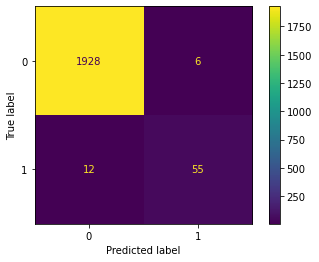

In [25]:
model_tree.fit(X_train,y_train)
y_pred = model_tree.predict(X_val)
conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_val,y_pred),display_labels=model_tree.classes_)
conf_mat.plot()

In [26]:
print(f'Miss rate: {false_negative_rate(y_val,y_pred):.3f}')

Miss rate: 0.179


[Text(418.5, 747.4499999999999, 'power_W <= 2.367\ngini = 0.068\nsamples = 4666\nvalue = [4501, 165]'),
 Text(257.53846153846155, 611.55, 'diff_temperature_air_process <= 2.543\ngini = 0.049\nsamples = 4613\nvalue = [4496, 117]'),
 Text(193.15384615384616, 475.65, 'diff_temperature_air_process <= -2.621\ngini = 0.04\nsamples = 4590\nvalue = [4496, 94]'),
 Text(128.76923076923077, 339.74999999999994, 'gini = 0.0\nsamples = 13\nvalue = [0, 13]'),
 Text(257.53846153846155, 339.74999999999994, 'tool_wear_min <= -1.352\ngini = 0.035\nsamples = 4577\nvalue = [4496, 81]'),
 Text(128.76923076923077, 203.8499999999999, 'process_temperature_k <= -0.875\ngini = 0.249\nsamples = 364\nvalue = [311, 53]'),
 Text(64.38461538461539, 67.94999999999993, 'gini = 0.215\nsamples = 57\nvalue = [7, 50]'),
 Text(193.15384615384616, 67.94999999999993, 'gini = 0.019\nsamples = 307\nvalue = [304, 3]'),
 Text(386.3076923076923, 203.8499999999999, 'torque_nm <= 1.491\ngini = 0.013\nsamples = 4213\nvalue = [4185, 2

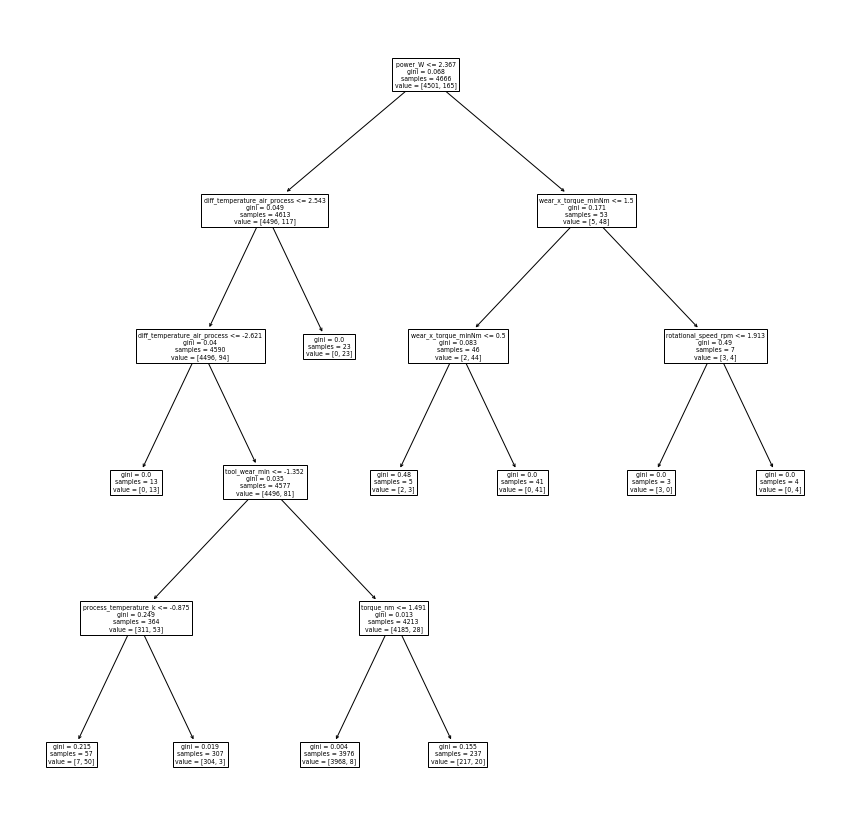

In [27]:
model_tree.get_params
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plot_tree(model_tree['Classifier'],feature_names=X.columns)

## Ensemble: Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier

#Para a árvore de decisão não precisaremos de OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

#preprocessor_rfc = ColumnTransformer(
#    [('numerical',StandardScaler(),num_features),
#    ('categorical',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1),cat_features)]
#)

preprocessor_rfc = ColumnTransformer(
    [('categorical',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1),cat_features)],
    remainder='passthrough')

#Modelo usando os dados balanceados pelas classes
#model_tree = Pipeline(steps=[
#    ('column_transformation',transformation),
#    ('Classifier',DecisionTreeClassifier(class_weight={0:class_weights[0],1:class_weights[1]}))
#])

model_rfc = Pipeline(steps=[
    ('preprocessor',preprocessor_rfc),
    ('Classifier',RandomForestClassifier(random_state=42))
])


display(model_rfc)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['type'])])),
                ('Classifier', RandomForestClassifier(random_state=42))])

In [29]:
rfc_grid = {
    'Classifier__criterion':['gini', 'entropy'],
    'Classifier__n_estimators':[100,150,200,300],
    'Classifier__max_depth':[1,2,5,10],
    'Classifier__max_leaf_nodes':[2,5,10,15]
}

search_rfc = GridSearchCV(model_rfc,
                      param_grid=rfc_grid,
                      scoring= miss_rate,
                     cv = 5)

search_rfc.fit(X_train,y_train)
search_rfc.best_params_

{'Classifier__criterion': 'entropy',
 'Classifier__max_depth': 10,
 'Classifier__max_leaf_nodes': 15,
 'Classifier__n_estimators': 100}

In [30]:
model_rfc.set_params(**search_rfc.best_params_)
print(model_rfc['Classifier'].get_params)

<bound method BaseEstimator.get_params of RandomForestClassifier(criterion='entropy', max_depth=10, max_leaf_nodes=15,
                       random_state=42)>


Miss rate: 0.194


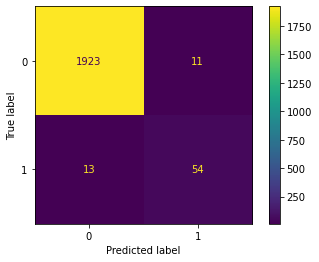

In [31]:
model_rfc.fit(X_train,y_train)
y_pred = model_rfc.predict(X_val)
conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_val,y_pred),display_labels=model_tree.classes_)
conf_mat.plot()
print(f'Miss rate: {false_negative_rate(y_val,y_pred):.3f}')

Com os resultados obtidos por meio dos três modelos acima, chegamos que o melhor modelo, dada a métrica escolhida, é o de Árvore de decisão. Por isso, agora vamos treiná-lo com todo o dataset de treino (X e y) para finalmente fazer o predict no arquivo final de teste, ainda não trabalhado. 

# Treino do modelo final

In [32]:
model_tree.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('column_transformation',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['air_temperature_k',
                                                   'process_temperature_k',
                                                   'rotational_speed_rpm',
                                                   'torque_nm', 'tool_wear_min',
                                                   'diff_temperature_air_process',
                                                   'power_W',
                                                   'wear_x_torque_minNm']),
                                                 ('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['type'])])),
 

In [33]:
#Ajustando o modelo a todo conjunto de treino
_ = model_tree.fit(X,y)

In [34]:
teste = pd.read_csv('desafio_manutencao_preditiva_teste_final.csv')
teste.head()

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,diff_temperature_air_process,power_W,wear_x_torque_minNm
0,L,297.5,308.6,1793,26.7,70,11.1,5013.3,1869.0
1,L,300.7,310.5,1536,47.4,192,9.8,7624.3,9100.8
2,L,297.2,308.4,1460,42.1,41,11.2,6436.7,1726.1
3,L,299.4,309.1,1670,35.9,68,9.7,6278.3,2441.2
4,L,304.1,313.1,1550,30.9,9,9.0,5015.6,278.1


In [35]:
y_pred_final = model.predict(teste)
y_pred_final[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [36]:
y_pred_final = pd.DataFrame(np.where(y_pred_final==0,'No Failure','Failure'),columns=['predictedValues'])
y_pred_final.head(10)

,predictedValues
0,No Failure
1,No Failure
2,No Failure
3,No Failure
4,No Failure
5,No Failure
6,No Failure
7,No Failure
8,No Failure
9,No Failure


In [37]:
y_pred_final.value_counts()

predictedValues
No Failure         3299
Failure              34
dtype: int64

In [39]:
y_pred_final.to_csv('predicted.csv',index=True,header=['predictedValues'],index_label='rowNumber')